In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

np.random.seed(0)

In [2]:
# em média, 252 dias úteis no ano
NUM_TRADING_DAYS = 252
# vamos gerar w aleatórios (diferentes portfólios)
NUM_PORTFOLIOS = 10000

## Carregamento dos dados

In [3]:
# os papeis que utilizaremos
stocks = ['VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA', 'PETR4.SA', 'MGLU3.SA']

In [55]:
# definir início e fim dos dados históricos
start_date = '2015-01-01'
end_date = '2018-01-01'

In [56]:
# download dos dados
stock_data = {}

for stock in stocks:
    # utilizaremos o processo de fechamento
    ticker = yf.Ticker(stock)
    stock_data[stock] = ticker.history(start = start_date, end = end_date)['Close']

dataset = pd.DataFrame(stock_data)

In [57]:
dataset

,VALE3.SA,ITUB4.SA,BBDC4.SA,ABEV3.SA,PETR4.SA,MGLU3.SA
Date,,,,,,
2015-01-02,14.682981,13.574777,11.977680,12.145536,7.057713,0.215259
2015-01-05,14.462183,13.642994,12.001722,11.925672,6.454489,0.219304
2015-01-06,15.041772,13.863688,12.396541,12.380563,6.243361,0.216414
2015-01-07,15.593766,14.365268,12.889192,12.554935,6.537433,0.223638
2015-01-08,15.759365,14.589970,12.955571,13.311450,6.959689,0.221905
...,...,...,...,...,...,...
2017-12-25,30.397150,23.885302,19.322273,18.518194,11.875957,2.196748
2017-12-26,30.442987,23.980776,19.319057,18.711918,12.041846,2.276042
2017-12-27,30.450626,23.851606,19.342260,18.844002,12.102167,2.330616


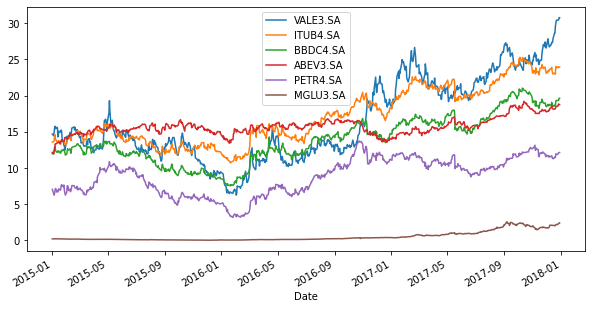

In [58]:
dataset.plot(figsize=(10, 5))
plt.show()

<AxesSubplot:xlabel='Date'>

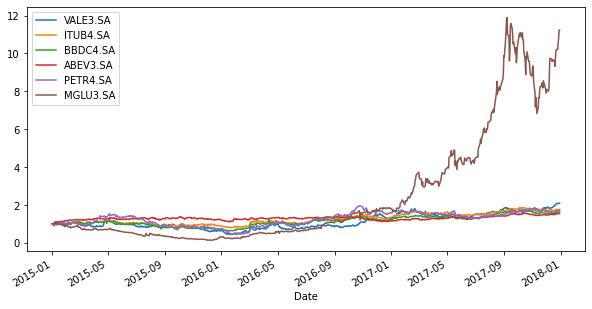

In [59]:
(dataset / dataset.iloc[0]).plot(figsize=(10,5))

## Normalização dos dados e cálculo dos retornos

In [60]:
# normalização - medir todas as variáveis em métrica comparável - log
log_return = np.log(dataset / dataset.shift(1)) # S(t+1) / S(t)
log_daily_returns = log_return[1:] # desconsiderando a primeira linha

In [61]:
# em vez de métricas diárias, buscamos métricas anuais
# média de retorno anual 
print(log_daily_returns.mean() * NUM_TRADING_DAYS)
print(log_daily_returns.cov() * NUM_TRADING_DAYS)
# temos um retorno médio anual de 20% na apple, 33% na tela e no DB se perde dinheiro

VALE3.SA    0.249104
ITUB4.SA    0.190760
BBDC4.SA    0.166471
ABEV3.SA    0.146082
PETR4.SA    0.182725
MGLU3.SA    0.815000
dtype: float64
          VALE3.SA  ITUB4.SA  BBDC4.SA  ABEV3.SA  PETR4.SA  MGLU3.SA
VALE3.SA  0.308152  0.063274  0.073587  0.032292  0.146506  0.081119
ITUB4.SA  0.063274  0.097284  0.095265  0.028767  0.103908  0.056622
BBDC4.SA  0.073587  0.095265  0.124969  0.029951  0.117807  0.069323
ABEV3.SA  0.032292  0.028767  0.029951  0.041666  0.038165  0.026276
PETR4.SA  0.146506  0.103908  0.117807  0.038165  0.293546  0.089205
MGLU3.SA  0.081119  0.056622  0.069323  0.026276  0.089205  0.544265


## Gerando carteiras para 10000 pesos aleatórios

In [62]:
portfolio_means = []
portfolio_risks = []
portfolio_weights = []

for _ in range(NUM_PORTFOLIOS):
    w = np.random.random(len(stocks))
    w /= np.sum(w) # normalizing

    mean = np.sum(log_daily_returns.mean() * w) * NUM_TRADING_DAYS
    risk = np.sqrt(np.dot(w.T, np.dot(log_daily_returns.cov() * NUM_TRADING_DAYS, w))) # W.T*(COV)*W

    portfolio_weights.append(w)
    portfolio_means.append(mean)
    portfolio_risks.append(risk)

pweights, means, risks = np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

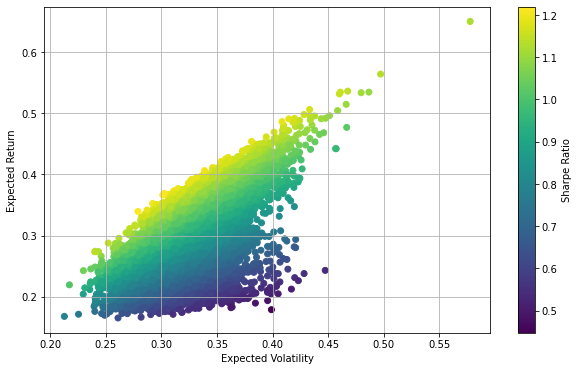

In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(risks, means, c=means/risks, marker = 'o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()

## Otimização para encontrar carteira ótima

In [64]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean()*weights) * NUM_TRADING_DAYS
    portfolio_volatility =  np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    
    return np.array([portfolio_return, portfolio_volatility, sharpe_ratio])

In [65]:
# scipy optimize encontra o míniomo de uma função
# o máximo de f(x) é o mínimo de -f(x)

def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2] # índice de Sharpe

In [66]:
# f(x) = 0 é a função que minimizaremos, que no caso é o índice Sharpe

# restrição: a soma dos pesos = 1 
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1 }

# os pesos podem ser 1 no máximo: 1 quando 100% do dinheiro é investido em uma única ação
bounds = [tuple((0, 1)) for _ in range(len(stocks))] # [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

optimum =  optimization.minimize(fun = min_function_sharpe, x0 = pweights[0], args = log_daily_returns, method='SLSQP', bounds = bounds, constraints = constraints)

In [67]:
print('Carteira ótima: ', optimum['x'].round(3))
print('Retorno esperado, volatilidade e índice Sharpe: ', statistics(optimum['x'].round(3), log_daily_returns))

Carteira ótima:  [0.032 0.104 0.    0.546 0.    0.318]
Retorno esperado, volatilidade e índice Sharpe:  [0.36674134 0.29692512 1.23513072]


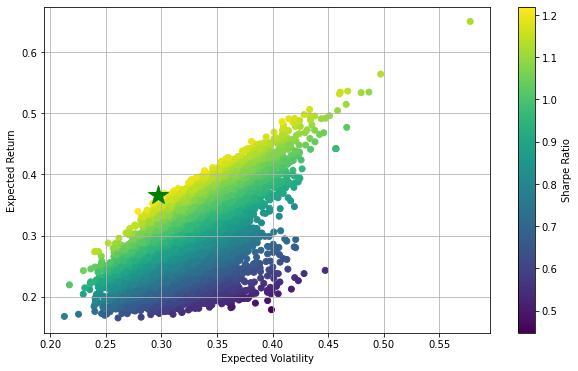

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(risks, means, c=means / risks, marker = 'o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.plot(statistics(optimum['x'], log_daily_returns)[1], statistics(optimum['x'], log_daily_returns)[0], 'g*', markersize=20.0)
plt.show()